In [ ]:
#################################################'''
# Library
############################################################

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
#sys.path.append('/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/')
import utils
#import settings


plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
from sklearn.preprocessing import StandardScaler
import pickle #pour charger un scaler déjà entrainé

In [15]:
#################################################
# Chargement des données
#################################################

In [16]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

In [17]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [18]:
#################################################
# Traintement des fichiers 
#################################################

In [19]:
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge

In [20]:
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [21]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

In [22]:
#regroupement selon la date

In [23]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_train_observed_a, train_a, on='date_forecast', how='inner')

merged_df_pre_b = pd.merge(X_train_observed_b, train_b, on='date_forecast', how='inner')

merged_df_pre_c = pd.merge(X_train_observed_c, train_c, on='date_forecast', how='inner')

In [24]:
#################################################
# Normalize function
#################################################

In [25]:
#normalize function
def normalize_dataframe(df):
    """
    Normalizes a DataFrame using the min-max scaling method.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The normalized DataFrame.
    """
    # Copy the input DataFrame to avoid modifying the original
    normalized_df = df.copy()

    # Iterate through each numeric column and apply min-max scaling
    for column in normalized_df.columns:
        if pd.api.types.is_numeric_dtype(normalized_df[column]):
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if min_val != max_val:
                normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)

    return normalized_df

In [26]:
merged_df_pre_a = normalize_dataframe(merged_df_pre_a)
merged_df_pre_b = normalize_dataframe(merged_df_pre_b)
merged_df_pre_c = normalize_dataframe(merged_df_pre_c)

In [ ]:
#################################################
# XGBoost Model 
#################################################

In [27]:
split_date_a = pd.to_datetime("2022-01-01")

In [30]:
merged_df_pre_a.index = pd.to_datetime(merged_df_pre_a.index)
merged_df_pre_b.index = pd.to_datetime(merged_df_pre_b.index)
merged_df_pre_c.index = pd.to_datetime(merged_df_pre_c.index)

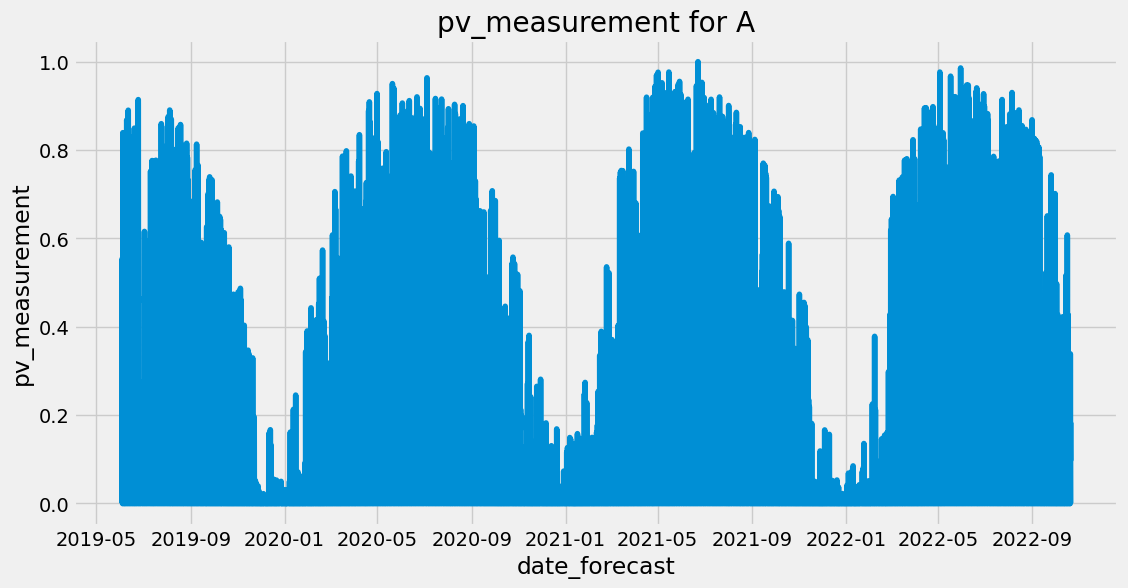

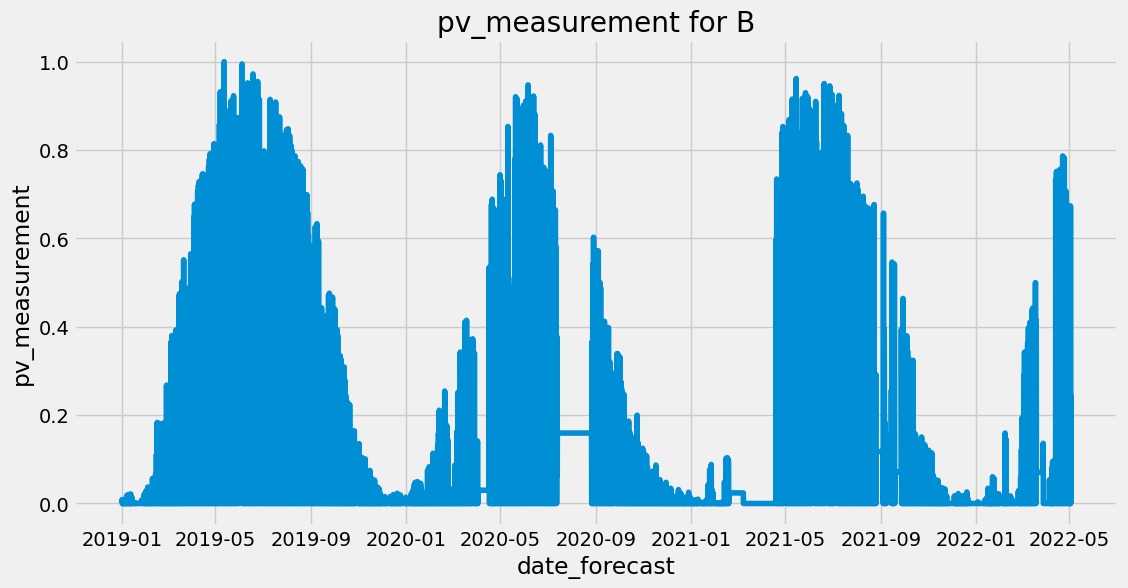

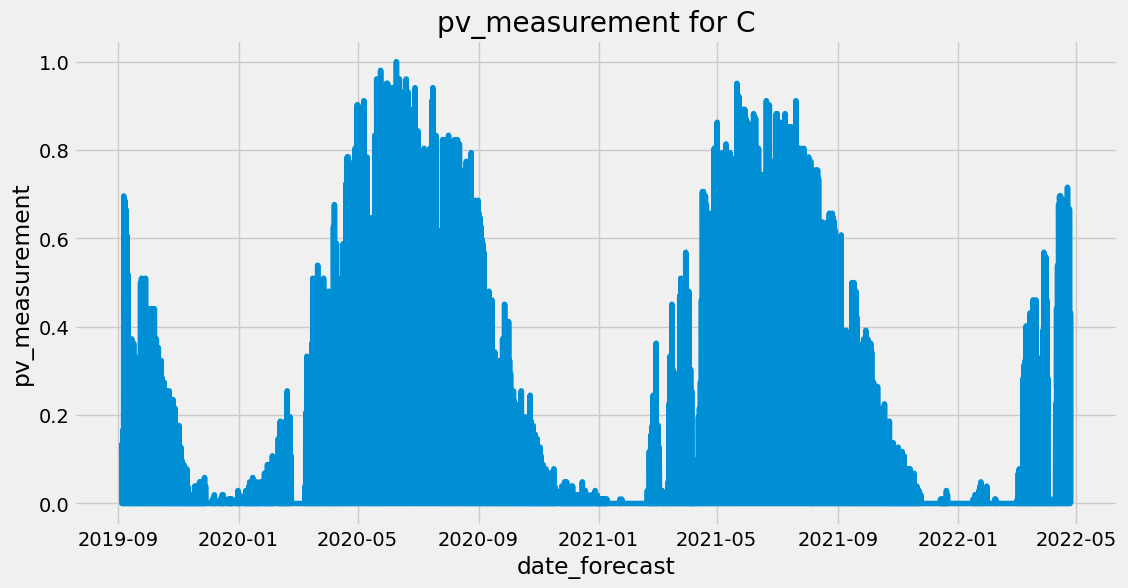

In [31]:
plt.figure(figsize=(12, 6)) 
plt.plot(merged_df_pre_a['date_forecast'], merged_df_pre_a['pv_measurement'])
plt.title('pv_measurement for A')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(merged_df_pre_b['date_forecast'], merged_df_pre_b['pv_measurement'])
plt.title('pv_measurement for B')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(merged_df_pre_c['date_forecast'], merged_df_pre_c['pv_measurement'])
plt.title('pv_measurement for C')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

In [32]:
pv_train_a = merged_df_pre_a[merged_df_pre_a['date_forecast'] <= split_date_a].copy()
pv_test_a = merged_df_pre_a[merged_df_pre_a['date_forecast'] > split_date_a].copy()

pv_train_b = merged_df_pre_b[merged_df_pre_b['date_forecast'] <= split_date_a].copy()
pv_test_b = merged_df_pre_b[merged_df_pre_b['date_forecast'] > split_date_a].copy()

pv_train_c = merged_df_pre_c[merged_df_pre_c['date_forecast'] <= split_date_a].copy()
pv_test_c = merged_df_pre_c[merged_df_pre_c['date_forecast'] > split_date_a].copy()

In [33]:
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

In [35]:
#function to apply XGBoost model
def create_features(df, label):
    """
    Creates time series features including datetime and additional columns from the original DataFrame
    """
    # Add additional columns to X
    additional_columns = [
        'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
        'clear_sky_rad:W', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
        'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p',
        'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
        'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
        'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa',
        'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
        'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
        'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
        't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms'
    ]
    
    X = df[additional_columns]
    
    if label:
        y = df[label]
        return X, y
    return X

In [36]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

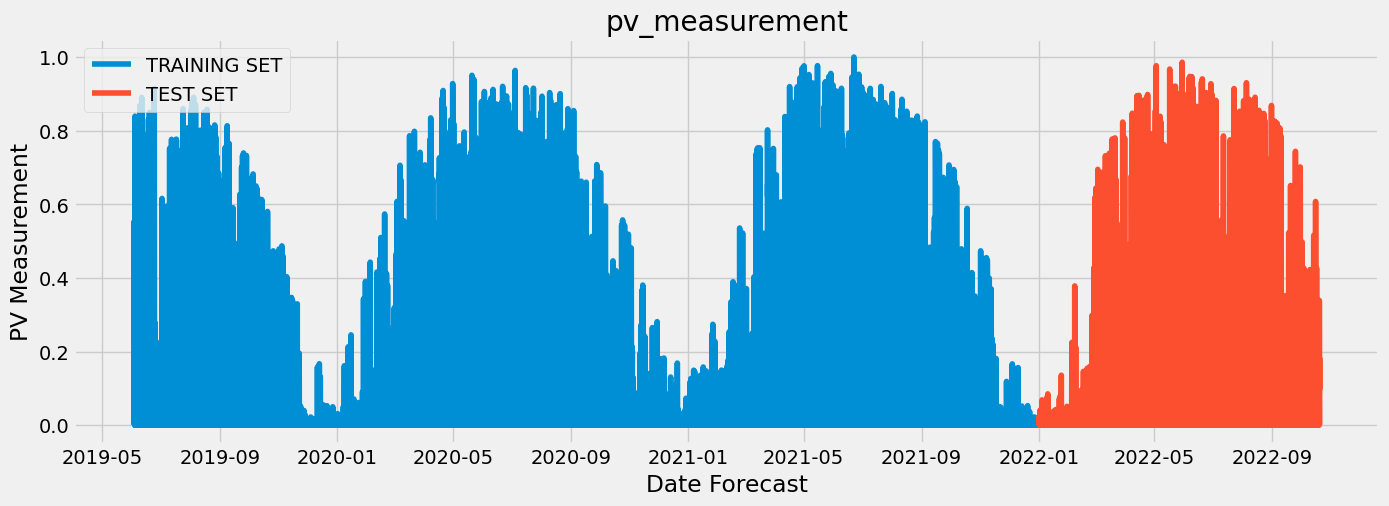

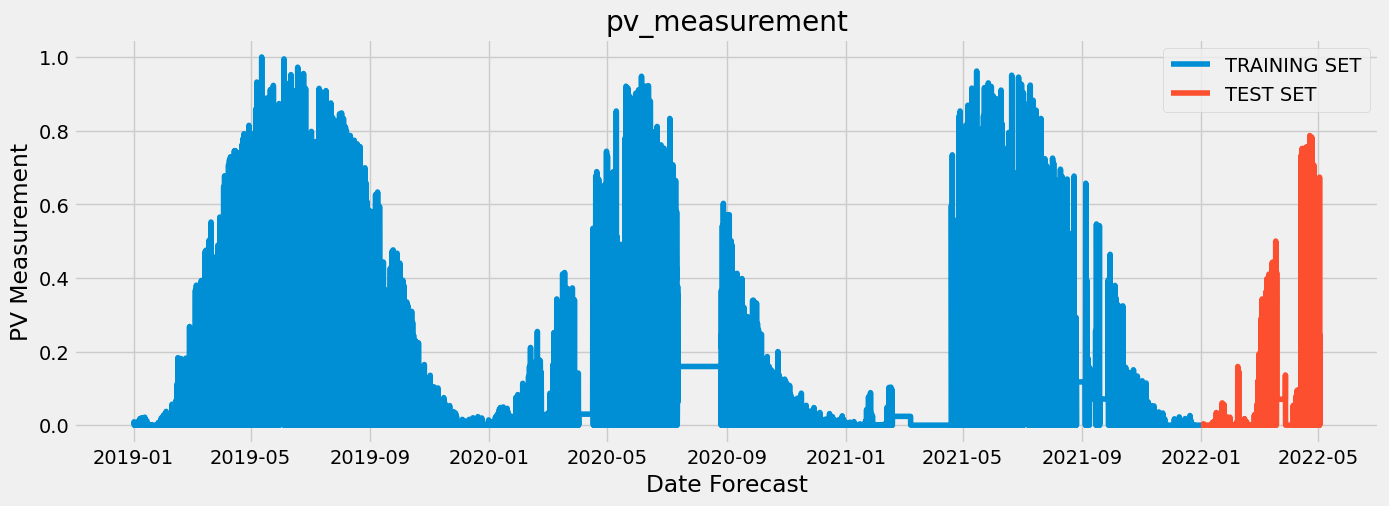

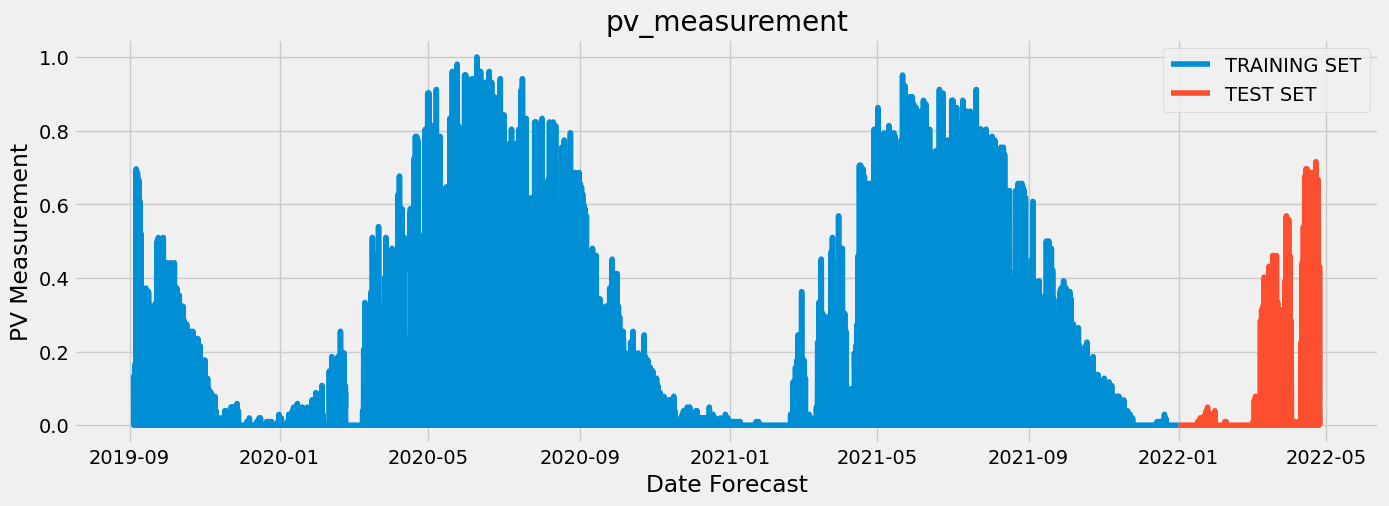

In [37]:
# Créez le graphique en fonction de "date_forecast"
plt.figure(figsize=(15, 5))
plt.plot(pv_train_a['date_forecast'], pv_train_a['pv_measurement'], label='TRAINING SET')
plt.plot(pv_test_a['date_forecast'], pv_test_a['pv_measurement'], label='TEST SET')
plt.title('pv_measurement')
plt.xlabel('Date Forecast')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(pv_train_b['date_forecast'], pv_train_b['pv_measurement'], label='TRAINING SET')
plt.plot(pv_test_b['date_forecast'], pv_test_b['pv_measurement'], label='TEST SET')
plt.title('pv_measurement')
plt.xlabel('Date Forecast')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(pv_train_c['date_forecast'], pv_train_c['pv_measurement'], label='TRAINING SET')
plt.plot(pv_test_c['date_forecast'], pv_test_c['pv_measurement'], label='TEST SET')
plt.title('pv_measurement')
plt.xlabel('Date Forecast')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()

In [38]:
reg_a = xgb.XGBRegressor(n_estimators=10000)
reg_a.fit(X_train_a, y_train_a,
          eval_set=[(X_train_a, y_train_a), (X_test_a, y_test_a)],
          early_stopping_rounds=50,
          verbose=True) 

reg_b = xgb.XGBRegressor(n_estimators=10000)
reg_b.fit(X_train_b, y_train_b,
          eval_set=[(X_train_b, y_train_b), (X_test_b, y_test_b)],
          early_stopping_rounds=50,
          verbose=True) 

reg_c = xgb.XGBRegressor(n_estimators=10000)
reg_c.fit(X_train_c, y_train_c,
          eval_set=[(X_train_c, y_train_c), (X_test_c, y_test_c)],
          early_stopping_rounds=50,
          verbose=True) 

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:0.15567	validation_1-rmse:0.16777
[1]	validation_0-rmse:0.12332	validation_1-rmse:0.13487
[2]	validation_0-rmse:0.10290	validation_1-rmse:0.11504
[3]	validation_0-rmse:0.09048	validation_1-rmse:0.10252
[4]	validation_0-rmse:0.08296	validation_1-rmse:0.09526
[5]	validation_0-rmse:0.07831	validation_1-rmse:0.09139
[6]	validation_0-rmse:0.07503	validation_1-rmse:0.08867
[7]	validation_0-rmse:0.07274	validation_1-rmse:0.08761
[8]	validation_0-rmse:0.07120	validation_1-rmse:0.08729
[9]	validation_0-rmse:0.06997	validation_1-rmse:0.08668
[10]	validation_0-rmse:0.06860	validation_1-rmse:0.08663
[11]	validation_0-rmse:0.06750	validation_1-rmse:0.08663
[12]	validation_0-rmse:0.06625	validation_1-rmse:0.08665
[13]	validation_0-rmse:0.06564	validation_1-rmse:0.08719
[14]	validation_0-rmse:0.06488	validation_1-rmse:0.08705
[15]	validation_0-rmse:0.06444	validation_1-rmse:0.08696
[16]	validation_0-rmse:0.06339	validation_1-rmse:0.08718
[17]	validation_0-rmse:0.06262	validation

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:0.13690	validation_1-rmse:0.10757
[1]	validation_0-rmse:0.11102	validation_1-rmse:0.09208
[2]	validation_0-rmse:0.09474	validation_1-rmse:0.08368
[3]	validation_0-rmse:0.08502	validation_1-rmse:0.08017
[4]	validation_0-rmse:0.07906	validation_1-rmse:0.07782
[5]	validation_0-rmse:0.07480	validation_1-rmse:0.07526
[6]	validation_0-rmse:0.07197	validation_1-rmse:0.07432
[7]	validation_0-rmse:0.07002	validation_1-rmse:0.07424
[8]	validation_0-rmse:0.06822	validation_1-rmse:0.07227
[9]	validation_0-rmse:0.06723	validation_1-rmse:0.07155
[10]	validation_0-rmse:0.06612	validation_1-rmse:0.07149
[11]	validation_0-rmse:0.06469	validation_1-rmse:0.07228
[12]	validation_0-rmse:0.06404	validation_1-rmse:0.07235
[13]	validation_0-rmse:0.06334	validation_1-rmse:0.07241
[14]	validation_0-rmse:0.06259	validation_1-rmse:0.07260
[15]	validation_0-rmse:0.06183	validation_1-rmse:0.07302
[16]	validation_0-rmse:0.06120	validation_1-rmse:0.07315
[17]	validation_0-rmse:0.06054	validation

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:0.10085	validation_1-rmse:0.08054
[2]	validation_0-rmse:0.08102	validation_1-rmse:0.06958
[3]	validation_0-rmse:0.06843	validation_1-rmse:0.06430
[4]	validation_0-rmse:0.06041	validation_1-rmse:0.06092
[5]	validation_0-rmse:0.05538	validation_1-rmse:0.05835
[6]	validation_0-rmse:0.05228	validation_1-rmse:0.05676
[7]	validation_0-rmse:0.05014	validation_1-rmse:0.05615
[8]	validation_0-rmse:0.04888	validation_1-rmse:0.05610
[9]	validation_0-rmse:0.04781	validation_1-rmse:0.05520
[10]	validation_0-rmse:0.04720	validation_1-rmse:0.05498
[11]	validation_0-rmse:0.04638	validation_1-rmse:0.05513
[12]	validation_0-rmse:0.04570	validation_1-rmse:0.05504
[13]	validation_0-rmse:0.04504	validation_1-rmse:0.05509
[14]	validation_0-rmse:0.04465	validation_1-rmse:0.05472
[15]	validation_0-rmse:0.04437	validation_1-rmse:0.05459
[16]	validation_0-rmse:0.04408	validation_1-rmse:0.05458
[17]	validation_0-rmse:0.04365	validation_1-rmse:0.05469
[18]	validation_0-rmse:0.04334	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

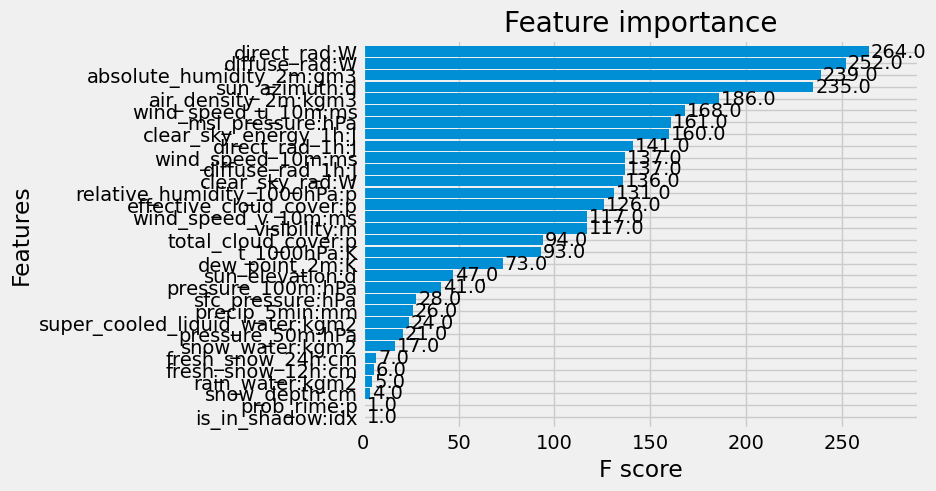

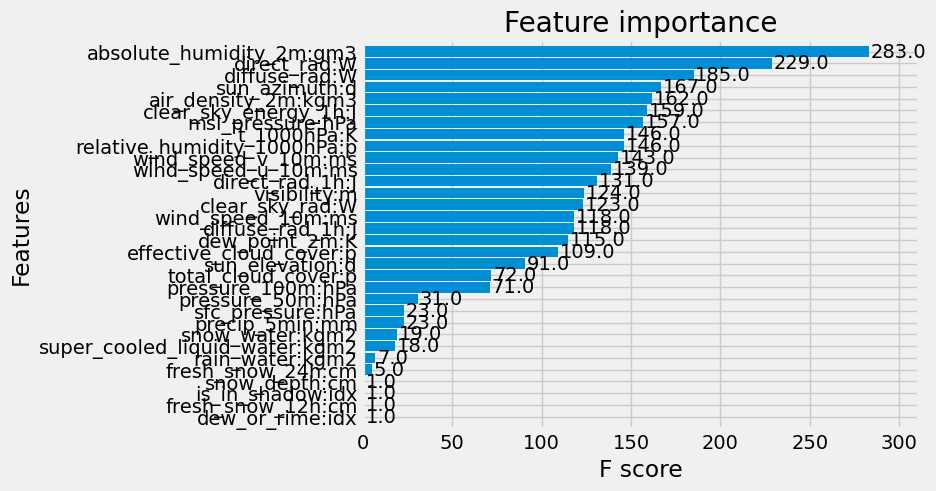

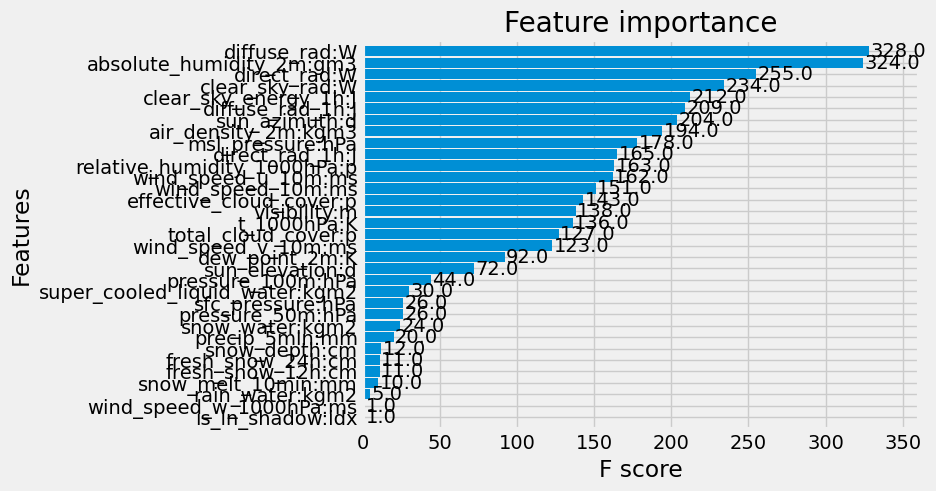

In [39]:
_ = plot_importance(reg_a, height=0.9)
_ = plot_importance(reg_b, height=0.9) 
_ = plot_importance(reg_c, height=0.9) 

In [40]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

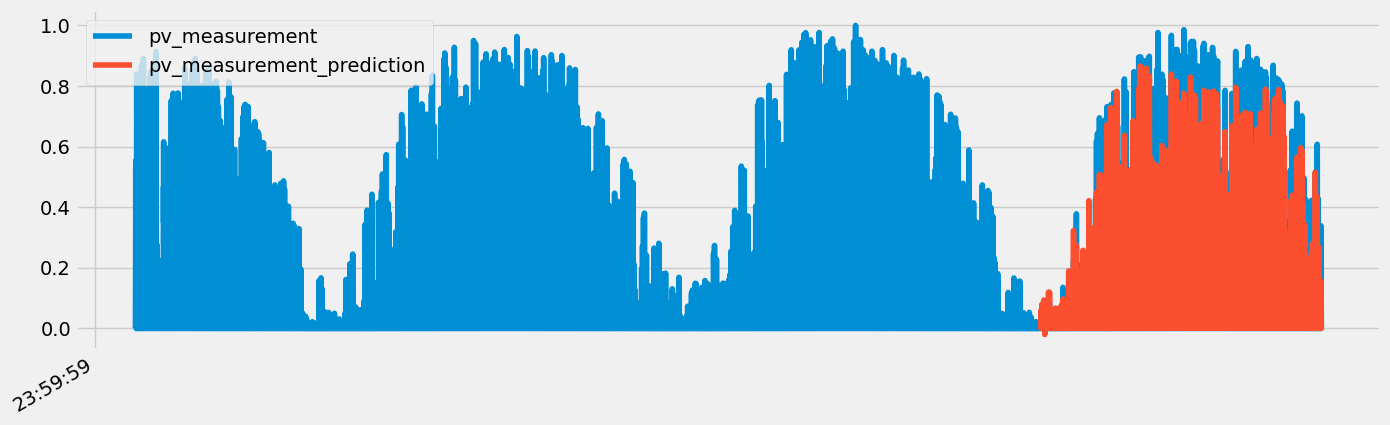

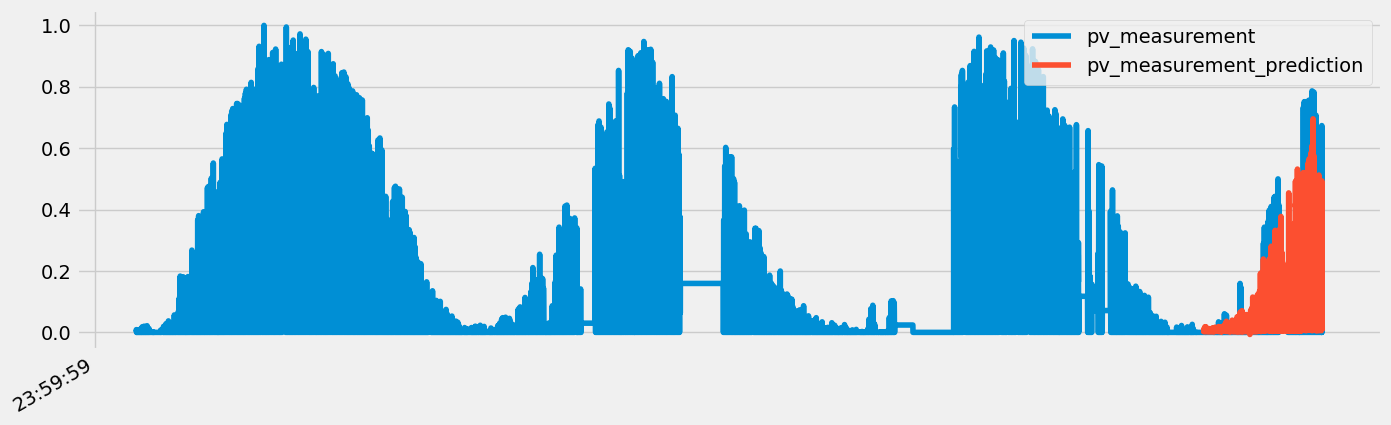

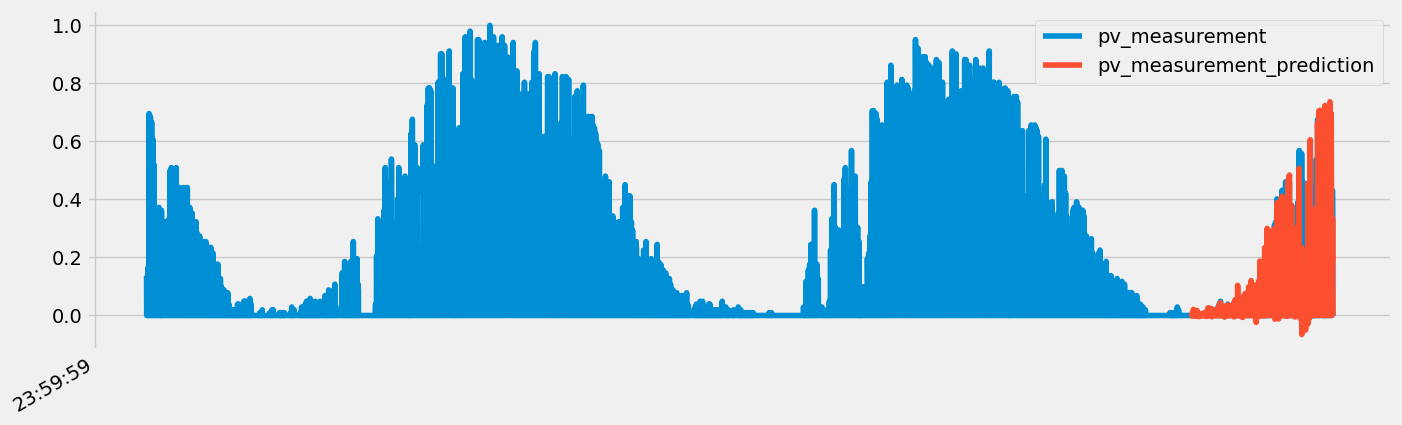

In [41]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))